In [457]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

# Data understanding

## Data loading

In [368]:
df = pd.read_csv('../data/dataset_tagged.csv')
df.shape

(77983, 4)

In [369]:
df.head()

,First Name,Last Name,Management Level,Title
0,Ann,Beard,NaN,"Senior Manager, Enterprise Readiness"
1,Christy,Stropes,NaN,Senior Knowledge Management Coordinator
2,Eric,Kerr,NaN,NaN
3,Andrew,Beam,NaN,Work At Home Department Manager
4,Suzana,Djordjevic,Manager-Level,Director of Operations


In [370]:
df = df.rename(
    columns={
        'Management Level': 'management_level',
        'Title': 'title'
    }
)

## Data exploration

### Missing values

In [371]:
df.isna().sum()

First Name            37
Last Name              0
management_level    1807
title                403
dtype: int64

### Features

In [372]:
df['title'].unique().shape

(46483,)

In [373]:
df['management_level'].value_counts()

Director-Level    31418
VP-Level          29794
Manager-Level      7094
C-Level            4226
Other              3608
Director             31
Manager               4
Non-Manager           1
Name: management_level, dtype: int64

In [374]:
# Unify categories

df['management_level'] = np.where(
    df['management_level'] == 'Non-Manager',
    'Other',
    df['management_level']
)

df['management_level'] = np.where(
    df['management_level'] == 'Manager',
    'Manager-Level',
    df['management_level']
)

df['management_level'] = np.where(
    df['management_level'] == 'Director',
    'Director-Level',
    df['management_level']
)


# Fill NANs with default value

df['management_level'] = np.where(
    df['management_level'].isna(),
    'Other',
    df['management_level']
)

df['title_filled'] = np.where(
    df['title'].isna(),
    'None',
    df['title']
).astype(str)

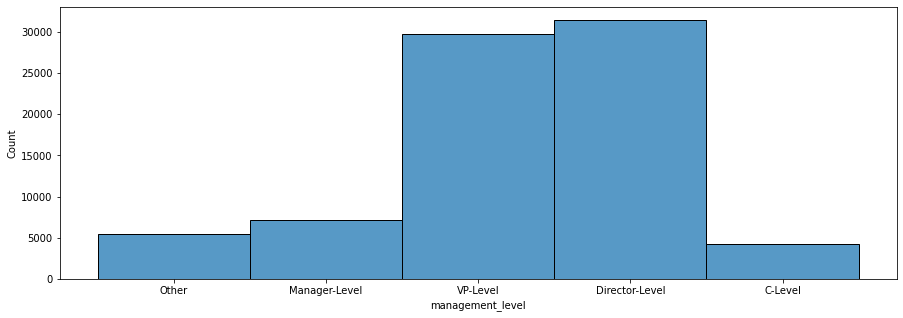

In [375]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['management_level'], discrete=True, ax=ax)
plt.show()

## Keywords-in-title analysis

### Add basic rule-of-thumb features

In [535]:
relevant_title_parts_per_management_level = {
    'c_level': [
        'chief', 'ceo', 'cto', 'cpo', 'cso', 'coo', 'cfo', 'cmo', 'cio', 'cao', 'chro',
        'president', 'global head'
    ],
    'vp_level': ['vp', 'vice president', 'vice-president'],
    'director_level': ['director', 'dir.', 'directeur'],
    'manager_level': ['manager', 'team lead', 'team-lead'],
}

substrings_to_exclude_per_management_level = {
    'c_level': ['coordin', 'director', 'vice'],
    'vp_level': [],
    'director_level': [],
    'manager_level': [],
}

In [536]:
def check_if_title_contains_keyword(title, list_of_keywords):
    for keyword in list_of_keywords:
        if keyword in title.lower():
            return 1
    return 0

In [537]:
for level, list_of_keywords in relevant_title_parts_per_management_level.items():
    df[f'title_has_{level}_parts'] = df['title_filled'].apply(
        lambda title: check_if_title_contains_keyword(title, list_of_keywords)
    )


for level, substrings_to_exclude in substrings_to_exclude_per_management_level.items():
    for sub_s in substrings_to_exclude:
        df[f'title_has_{level}_parts'] = np.where(
            (df[f'title_has_{level}_parts'] == 1) &
            (df['title_filled'].apply(lambda s: s.lower()).str.contains(sub_s)),
            0,
            df[f'title_has_{level}_parts']
        )

In [538]:
df['title_filled'].apply(lambda s: s.lower())

0                senior manager, enterprise readiness
1             senior knowledge management coordinator
2                                                none
3                     work at home department manager
4                              director of operations
                             ...                     
77978        head of international markets operations
77979                       people operations manager
77980    global head of claims operational excellence
77981                      director of transformation
77982           operations manager, customer services
Name: title_filled, Length: 77983, dtype: object

In [539]:
# tdf = pd.DataFrame(
#     {
#         'title_filled': df['title_filled'],
#         'has_vice': ((df['title_filled'].apply(lambda s: s.lower()).str.contains('vice')) & (~df['title_filled'].apply(lambda s: s.lower()).str.contains('service'))).astype(int).values
#     }
# )
# tdf

In [540]:
title_parts_columns = [f'title_has_{level}_parts' for level in relevant_title_parts_per_management_level.keys()]
df[['title_filled'] + title_parts_columns].head()

,title_filled,title_has_c_level_parts,title_has_vp_level_parts,title_has_director_level_parts,title_has_manager_level_parts
0,"Senior Manager, Enterprise Readiness",0,0,0,1
1,Senior Knowledge Management Coordinator,0,0,0,0
2,None,0,0,0,0
3,Work At Home Department Manager,0,0,0,1
4,Director of Operations,0,0,1,0


### Analyze new features

In [541]:
df['title_parts_amount'] = df[title_parts_columns].sum(axis=1)

In [542]:
df['title_parts_amount'].value_counts()

1    65032
0     8319
2     4622
3       10
Name: title_parts_amount, dtype: int64

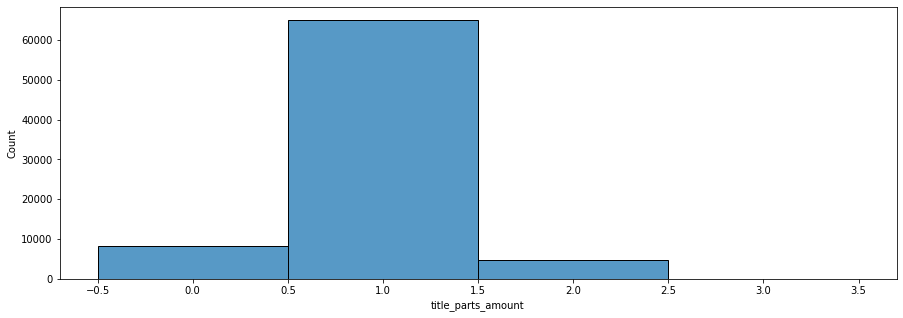

In [543]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['title_parts_amount'], discrete=True, ax=ax)
plt.show()

In [544]:
# df[
#     (df['management_level'] != 'C-Level') &
#     (df['title_filled'].str.contains('head'))
# ]

#### 0 title parts

In [545]:
no_title_parts_df = df[df['title_parts_amount'] == 0]
no_title_parts_df['management_level'].value_counts()

Other             4125
VP-Level          3522
Manager-Level      338
C-Level            264
Director-Level      70
Name: management_level, dtype: int64

In [546]:
# list(no_title_parts_df[
#     no_title_parts_df['management_level'] == 'C-Level'
# ]['title_filled'].unique())

#### "Other" management level analysis

In [547]:
other_management_level_df = df[df['management_level'] == 'Other']
other_management_level_df[title_parts_columns].mean()

title_has_c_level_parts           0.021418
title_has_vp_level_parts          0.054468
title_has_director_level_parts    0.094904
title_has_manager_level_parts     0.074040
dtype: float64

In [548]:
list(other_management_level_df[other_management_level_df.title_has_c_level_parts == 1].head().title_filled)

['Chief Operating Officer New Economy',
 'Chief Operating Officer Nearshore',
 'CSO CRM Operations',
 'Contractor',
 'Founder and CEO']

In [549]:
list(other_management_level_df[other_management_level_df.title_has_vp_level_parts == 1].head().title_filled)

['AVP',
 'VP - Sales & Marketing',
 'VP of Training and Talent Development',
 'VP Enterprise Partnerships',
 'Global Vice President, Comcast Operations']

In [550]:
list(other_management_level_df[other_management_level_df.title_has_director_level_parts == 1].head().title_filled)

['Director of Customer Experience',
 'Operations Senior Director, Human Resources',
 'Director Learning & Development EMEA',
 'Snr Director of Technology',
 'Director Information Technology Systems at Amdocs']

In [551]:
list(other_management_level_df[other_management_level_df.title_has_manager_level_parts == 1].head().title_filled)

['Senior Manager, Enterprise Readiness',
 'Work At Home Department Manager',
 'Manager, Cloud Campus Agile Team',
 'Team Leader, Portuguese Customer Solutions',
 'Team Leader, People & Culture Operations']

# Performance

## Assign predictions as the highest level found

In [565]:
management_level_mapping = {
    'Other': 0,
    'Manager-Level': 1,
    'Director-Level': 2,
    'VP-Level': 3,
    'C-Level': 4,
}

management_level_reverse_mapping = {
    0: 'Other',
    1: 'Manager-Level',
    2: 'Director-Level',
    3: 'VP-Level',
    4: 'C-Level'
}

In [566]:
df['management_level_int'] = df['management_level'].apply(
    lambda management_level: management_level_mapping[management_level]
)

In [567]:
# 'Other'
df['pred_int'] = 0 

# 'Manager-Level'
df['pred_int'] = np.where(
    df['title_has_manager_level_parts'] == 1,
    1,
    df['pred_int']
)

# 'Director-Level'
df['pred_int'] = np.where(
    df['title_has_director_level_parts'] == 1,
    2,
    df['pred_int']
)

# 'VP-Level'
df['pred_int'] = np.where(
    df['title_has_vp_level_parts'] == 1,
    3,
    df['pred_int']
)

# C-Level
df['pred_int'] = np.where(
    df['title_has_c_level_parts'] == 1,
    4,
    df['pred_int']
)

## Check performance

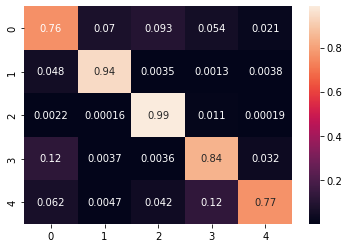

In [568]:
cm = confusion_matrix(df['management_level_int'], df['pred_int'])
cm_norm = []
for i in range(cm.shape[0]):
    curr_row = cm[i]
    cm_norm.append(curr_row / curr_row.sum())

cm_norm = np.array(cm_norm)

_ = sns.heatmap(cm_norm, annot=True)

In [569]:
# Accuracy
(df['management_level_int'] == df['pred_int']).mean()

0.9001961966069528

## Error analysis

In [570]:
df['pred'] = df['pred_int'].apply(
    lambda management_level_int: management_level_reverse_mapping[management_level_int]
)

In [571]:
df[
    (df['management_level_int'] == 0) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int').head()[['title_filled', 'management_level', 'pred']]

,title_filled,management_level,pred
0,"Senior Manager, Enterprise Readiness",Other,Manager-Level
28,Director of Customer Experience,Other,Director-Level
60,Chief Operating Officer New Economy,Other,C-Level
443,AVP,Other,VP-Level


In [572]:
df[
    (df['management_level_int'] == 1) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int').head()[['title_filled', 'management_level', 'pred']]

,title_filled,management_level,pred
4,Director of Operations,Manager-Level,Director-Level
87,"Manager, CSO & Solutions Operations Section",Manager-Level,C-Level
457,Training and Onboarding Manage,Manager-Level,Other
1196,VP Operations EMEA,Manager-Level,VP-Level


In [573]:
df[
    (df['management_level_int'] == 2) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int').head()[['title_filled', 'management_level', 'pred']]

,title_filled,management_level,pred
629,"VP - Training, Quality & Talent Development",Director-Level,VP-Level
1224,Global Deputy Chief Client Officer,Director-Level,C-Level
1817,"Readiness People & Culture Lead, Modern Life, ...",Director-Level,Other
6669,"National Program Manager, Tech",Director-Level,Manager-Level


In [574]:
df[
    (df['management_level_int'] == 3) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int').head()[['title_filled', 'management_level', 'pred']]

,title_filled,management_level,pred
5,Executive VP & Chief Financial Officer,VP-Level,C-Level
25,"Global Head, Customer Experience & Enterprise ...",VP-Level,Other
116,"Senior Head of Operations, Operations Manager",VP-Level,Manager-Level
141,Managing Director / Presidente Philip Morris F...,VP-Level,Director-Level


In [575]:
df[
    (df['management_level_int'] == 4) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int').head()[['title_filled', 'management_level', 'pred']]

,title_filled,management_level,pred
505,Director,C-Level,Director-Level
619,Coordinador de Comunicaciones,C-Level,Other
779,"Vice President, Strategic Initiatives (Office ...",C-Level,VP-Level
1742,"Deputy Head of Customer Service, Site Manager,...",C-Level,Manager-Level


In [576]:
df[
    (df['management_level_int'] == 4) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int').title_filled.iloc[-1]

'Deputy Head of Customer Service, Site Manager, CSM of Digital, Priority Services, Complaints & Esc'